# Contrarian Sentiment Trading Strategy Backtest

This notebook implements a contrarian sentiment trading strategy for business and cryptocurrency prediction markets on **Polymarket**.

**Core hypothesis:** Markets become overpriced when trading activity exceeds genuine public interest. When prediction market prices are high but Google search volume is low, it suggests speculative hype that will fade — creating SHORT opportunities.

**Signal:** `divergence = normalized_price - normalized_search_volume > 0.4` → SHORT

## Sections
1. Imports & Setup
2. DataProvider Class (market fetching, price history, Google Trends, keyword extraction)
3. Strategy Functions (signal generation, visualization, performance, cumulative P&L)
4. Main Execution

## 1. Imports & Setup

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import time
import json
from pytrends.request import TrendReq
from datetime import datetime, timedelta

## 2. DataProvider Class

In [ ]:
import os

class DataProvider:
    """Handles data collection: Polymarket markets, CLOB price history, and sentiment data."""

    CRYPTO_SYMBOLS = {
        'bitcoin': 'BTC', 'btc': 'BTC', 'ethereum': 'ETH', 'eth': 'ETH',
        'solana': 'SOL', 'sol': 'SOL', 'cardano': 'ADA', 'ada': 'ADA',
        'ripple': 'XRP', 'xrp': 'XRP', 'polkadot': 'DOT', 'dot': 'DOT',
        'dogecoin': 'DOGE', 'doge': 'DOGE', 'avalanche': 'AVAX', 'avax': 'AVAX',
        'polygon': 'MATIC', 'matic': 'MATIC', 'chainlink': 'LINK', 'link': 'LINK',
        'litecoin': 'LTC', 'ltc': 'LTC', 'shiba': 'SHIB', 'shib': 'SHIB',
        'bnb': 'BNB', 'binance coin': 'BNB', 'tron': 'TRX', 'trx': 'TRX',
        'uniswap': 'UNI', 'uni': 'UNI', 'aave': 'AAVE', 'cosmos': 'ATOM',
        'atom': 'ATOM', 'near': 'NEAR', 'aptos': 'APT', 'apt': 'APT',
        'arbitrum': 'ARB', 'arb': 'ARB', 'optimism': 'OP', 'sui': 'SUI', 'pepe': 'PEPE',
    }

    def __init__(self):
        self.gamma_api_url = "https://gamma-api.polymarket.com/markets"
        self.clob_history_url = "https://clob.polymarket.com/prices-history"

        self.business_crypto_keywords = [
            'bitcoin', 'ethereum', 'crypto', 'cryptocurrency', 'blockchain',
            'stock', 'price', 'trading', 'company', 'technology', 'finance',
            'solana', 'cardano', 'defi', 'nft', 'token', 'coin',
            'tesla', 'apple', 'microsoft', 'google', 'amazon', 'nvidia',
            'coinbase', 'binance', 'nasdaq', 'market cap', 'ipo',
            'recession', 'inflation', 'interest rate', 'economy',
            'earnings', 'revenue', 'shares', 'ticker', 'valuation',
            'tech', 'business', 'btc', 'eth'
        ]

        self.keyphrase_map = {
            'bitcoin': ['Bitcoin price', 'Bitcoin cryptocurrency'],
            'btc': ['Bitcoin price', 'BTC crypto'],
            'ethereum': ['Ethereum price', 'Ethereum crypto'],
            'eth': ['Ethereum price', 'ETH crypto'],
            'solana': ['Solana price', 'Solana crypto'],
            'cardano': ['Cardano price', 'Cardano ADA'],
            'ripple': ['Ripple XRP', 'XRP crypto'],
            'xrp': ['XRP price', 'Ripple XRP'],
            'polkadot': ['Polkadot price', 'Polkadot DOT'],
            'dogecoin': ['Dogecoin price', 'Dogecoin DOGE'],
            'doge': ['Dogecoin price', 'DOGE crypto'],
            'avalanche': ['Avalanche AVAX', 'Avalanche crypto'],
            'polygon': ['Polygon MATIC', 'Polygon crypto'],
            'chainlink': ['Chainlink LINK', 'Chainlink crypto'],
            'litecoin': ['Litecoin price', 'Litecoin LTC'],
            'shiba': ['Shiba Inu crypto', 'SHIB token'],
            'tesla': ['Tesla stock', 'Tesla electric car'],
            'apple': ['Apple stock', 'Apple technology'],
            'microsoft': ['Microsoft stock', 'Microsoft technology'],
            'google': ['Google stock', 'Alphabet stock'],
            'alphabet': ['Alphabet stock', 'Google company'],
            'amazon': ['Amazon stock', 'Amazon ecommerce'],
            'meta': ['Meta stock', 'Meta Facebook'],
            'nvidia': ['Nvidia stock', 'Nvidia GPU'],
            'netflix': ['Netflix stock', 'Netflix streaming'],
            'amd': ['AMD stock', 'AMD technology'],
            'intel': ['Intel stock', 'Intel technology'],
            'palantir': ['Palantir stock', 'Palantir PLTR'],
            'coinbase': ['Coinbase stock', 'Coinbase exchange'],
            'binance': ['Binance exchange', 'Binance crypto'],
            'kraken': ['Kraken exchange', 'Kraken crypto'],
            'recession': ['recession economy', 'economic recession'],
            'inflation': ['inflation rate', 'inflation economy'],
            'interest rate': ['interest rates', 'federal reserve rates'],
            'fed': ['Federal Reserve', 'Fed interest rates'],
            'stock market': ['stock market today', 'stock market news'],
            'nasdaq': ['Nasdaq index', 'Nasdaq stocks'],
            's&p 500': ['S&P 500 index', 'S&P 500 stocks'],
            'dow jones': ['Dow Jones index', 'Dow Jones stocks'],
        }

    def is_business_crypto_market(self, question, tags):
        """Check if a market is related to business or cryptocurrency."""
        question_lower = question.lower()
        if tags:
            for tag in tags:
                tag_lower = tag.lower() if isinstance(tag, str) else ''
                if any(kw in tag_lower for kw in self.business_crypto_keywords):
                    return True
        return any(kw in question_lower for kw in self.business_crypto_keywords)

    def extract_keywords(self, question, tags):
        """Extract 1-2 multi-word keyphrases optimized for Google Trends."""
        question_lower = question.lower()

        for trigger, keyphrases in self.keyphrase_map.items():
            if trigger in question_lower:
                return keyphrases[:2]

        category = None
        if tags:
            for tag in (tags if isinstance(tags, list) else [tags]):
                tag_lower = tag.lower() if isinstance(tag, str) else ''
                if any(w in tag_lower for w in ['crypto', 'blockchain', 'defi']):
                    category = 'crypto'
                    break
                if any(w in tag_lower for w in ['business', 'stock', 'finance', 'tech']):
                    category = 'stock'
                    break

        stop_words = {
            'will', 'the', 'be', 'on', 'at', 'in', 'to', 'of', 'for', 'and', 'or',
            'is', 'are', 'was', 'were', 'been', 'have', 'has', 'had', 'do', 'does',
            'did', 'can', 'could', 'would', 'should', 'may', 'might', 'must',
            'above', 'below', 'between', 'exactly', 'total', 'number', 'next',
            'before', 'after', 'than', 'more', 'less', 'over', 'under', 'by'
        }
        keyphrases = []
        words = question.split()
        i = 0
        while i < len(words):
            word = words[i].strip('?.,!;:()\"\'/$ ')
            if not word or len(word) <= 2 or word.lower() in stop_words:
                i += 1
                continue

            if word[0].isupper() and i > 0:
                phrase_parts = [word]
                for j in range(i + 1, min(i + 3, len(words))):
                    nw = words[j].strip('?.,!;:()\"\'/$ ')
                    if nw and nw[0].isupper() and len(nw) > 2 and nw.lower() not in stop_words:
                        phrase_parts.append(nw)
                    else:
                        break

                entity = ' '.join(phrase_parts)
                if any(w in question_lower for w in ['price', '$', 'reach', 'dip', 'hit']):
                    suffix = 'crypto' if category == 'crypto' else 'price'
                elif any(w in question_lower for w in ['stock', 'shares', 'market cap']):
                    suffix = 'stock'
                elif any(w in question_lower for w in ['crypto', 'blockchain', 'token']):
                    suffix = 'crypto'
                elif category == 'crypto':
                    suffix = 'crypto'
                elif category == 'stock':
                    suffix = 'stock'
                else:
                    suffix = 'price'
                keyphrases.append(f"{entity} {suffix}")
                i += len(phrase_parts)
                continue
            i += 1

        if keyphrases:
            return keyphrases[:2]

        if category == 'crypto':
            return ['cryptocurrency price', 'crypto market']
        elif category == 'stock':
            return ['stock market', 'stock price']
        return None

    def fetch_top_markets(self, limit=50):
        """Fetch top active business/crypto markets ordered by volume."""
        try:
            params = {
                "limit": 200, "closed": "false", "active": "true",
                "order": "volume", "ascending": "false"
            }
            response = requests.get(self.gamma_api_url, params=params)
            response.raise_for_status()
            data = response.json()
            print(f"Retrieved {len(data)} total markets from Gamma API")

            markets = []
            for item in data:
                question = item.get("question", "")
                tags = item.get("tags", [])

                if not self.is_business_crypto_market(question, tags):
                    continue

                keywords = self.extract_keywords(question, tags)
                if not keywords:
                    continue

                raw_ids = item.get("clobTokenIds")
                token_id = None
                if isinstance(raw_ids, list) and raw_ids:
                    token_id = raw_ids[0]
                elif isinstance(raw_ids, str):
                    try:
                        parsed = json.loads(raw_ids)
                        token_id = parsed[0] if isinstance(parsed, list) and parsed else raw_ids
                    except json.JSONDecodeError:
                        token_id = raw_ids

                if not token_id:
                    continue

                markets.append({"question": question, "keywords": keywords, "token_id": token_id})
                if len(markets) >= limit:
                    break

            print(f"Filtered to {len(markets)} active business/crypto markets")
            return markets

        except Exception as e:
            print(f"Market fetch failed: {e}")
            return []

    def fetch_market_history(self, token_id):
        """Fetch daily historical price data from the CLOB API."""
        try:
            params = {"market": token_id, "interval": "1d", "fidelity": 1}
            response = requests.get(self.clob_history_url, params=params)
            response.raise_for_status()
            data = response.json()

            if not data or 'history' not in data or not data['history']:
                return None

            df = pd.DataFrame(data['history'])
            if 't' not in df.columns or 'p' not in df.columns:
                return None

            df['timestamp'] = pd.to_datetime(df['t'], unit='s')
            df['price'] = df['p'].astype(float)
            df.set_index('timestamp', inplace=True)
            df = df[['price']].sort_index()
            return df if not df.empty else None

        except Exception as e:
            print(f"  Price history fetch failed: {e}")
            return None

    def fetch_fear_greed(self, days=90):
        """Fetch daily Crypto Fear & Greed Index from Alternative.me."""
        try:
            url = f"https://api.alternative.me/fng/?limit={days}&date_format=us"
            response = requests.get(url, timeout=15)
            response.raise_for_status()
            data = response.json()

            if 'data' not in data or not data['data']:
                return None

            rows = [{'timestamp': pd.to_datetime(e['timestamp']), 'search_volume': int(e['value'])} 
                    for e in data['data']]
            df = pd.DataFrame(rows).set_index('timestamp').sort_index()
            print(f"  Fear & Greed Index: {len(df)} daily data points")
            return df

        except Exception as e:
            print(f"  Fear & Greed fetch failed: {e}")
            return None

    def fetch_social_volume(self, coin_symbol, hours=2160):
        """Fetch hourly social media volume from CryptoCompare (requires API key)."""
        api_key = os.environ.get('CRYPTOCOMPARE_API_KEY')
        if not api_key:
            return None

        try:
            list_url = "https://min-api.cryptocompare.com/data/social/coin/list"
            list_resp = requests.get(list_url, params={'api_key': api_key}, timeout=15)
            list_resp.raise_for_status()
            coin_list = list_resp.json()

            coin_id = None
            if 'Data' in coin_list:
                for item in coin_list['Data']:
                    info = item if isinstance(item, dict) else coin_list['Data'][item]
                    symbol = info.get('Symbol', info.get('CoinInfo', {}).get('Name', ''))
                    if symbol.upper() == coin_symbol.upper():
                        coin_id = info.get('Id', info.get('CoinInfo', {}).get('Id'))
                        break

            if not coin_id:
                return None

            url = "https://min-api.cryptocompare.com/data/social/coin/histo/hour"
            params = {'coinId': coin_id, 'limit': min(hours, 2000), 'api_key': api_key}
            response = requests.get(url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()

            if 'Data' not in data or not data['Data']:
                return None

            rows = [{'timestamp': pd.to_datetime(e['time'], unit='s'),
                     'search_volume': e.get('comments', 0) + e.get('posts', 0) + e.get('followers', 0)}
                    for e in data['Data']]
            df = pd.DataFrame(rows).set_index('timestamp').sort_index()

            if df['search_volume'].sum() == 0:
                return None

            print(f"  CryptoCompare social data: {len(df)} hourly points for {coin_symbol}")
            return df

        except Exception as e:
            print(f"  CryptoCompare fetch failed: {e}")
            return None

    def _extract_coin_symbol(self, question, keywords):
        """Map a market question/keywords to a crypto ticker symbol."""
        text = (question + ' ' + ' '.join(keywords)).lower()
        for trigger, symbol in self.CRYPTO_SYMBOLS.items():
            if trigger in text:
                return symbol
        return None

    def fetch_google_trends(self, keywords, end_date):
        """Fetch 90 days of Google Trends data ending on the market end date."""
        if isinstance(keywords, str):
            keywords = [keywords]
        keywords = keywords[:5]

        try:
            if hasattr(end_date, 'date'):
                end_dt = end_date if isinstance(end_date, datetime) else datetime.combine(end_date, datetime.min.time())
            else:
                end_dt = datetime.combine(end_date, datetime.min.time()) if not isinstance(end_date, datetime) else end_date

            if end_dt.tzinfo is not None:
                end_dt = end_dt.replace(tzinfo=None)

            trends_start = end_dt - timedelta(days=90)
            tf = f"{trends_start.strftime('%Y-%m-%d')} {end_dt.strftime('%Y-%m-%d')}"

            print(f"  Google Trends query: {keywords}")
            print(f"  Timeframe: {tf}")

            max_retries, retry_delay = 3, 20

            for attempt in range(max_retries):
                try:
                    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10, 25))
                    pytrends.build_payload(keywords, timeframe=tf, geo='US', gprop='')
                    data = pytrends.interest_over_time()

                    if data.empty:
                        print(f"  No trends data returned")
                        return None

                    if 'isPartial' in data.columns:
                        data = data.drop(columns=['isPartial'])

                    available = [kw for kw in keywords if kw in data.columns]
                    if not available:
                        return None

                    result = pd.DataFrame()
                    result['search_volume'] = data[available].mean(axis=1)
                    print(f"  Retrieved trends: {len(result)} data points")
                    return result

                except Exception as e:
                    error_str = str(e).lower()
                    if '429' in error_str or 'rate' in error_str or 'quota' in error_str:
                        if attempt < max_retries - 1:
                            print(f"  Rate limited, retrying in {retry_delay}s...")
                            time.sleep(retry_delay)
                            retry_delay *= 2
                        else:
                            return None
                    else:
                        print(f"  Trends error: {e}")
                        return None
            return None
        except Exception as e:
            print(f"  Google Trends error: {e}")
            return None

    fetch_search_volume = fetch_google_trends

    def fetch_sentiment(self, market, price_end):
        """Unified sentiment data orchestrator. Tries CryptoCompare → Fear & Greed → Google Trends."""
        question, keywords = market['question'], market['keywords']
        coin_symbol = self._extract_coin_symbol(question, keywords)
        is_crypto = coin_symbol is not None

        if is_crypto:
            social_df = self.fetch_social_volume(coin_symbol)
            if social_df is not None and not social_df.empty:
                return social_df, f"Social Volume: {coin_symbol}", "convergence"

            fg_df = self.fetch_fear_greed(days=90)
            if fg_df is not None and not fg_df.empty:
                return fg_df, "Fear & Greed Index", "convergence"

        trends_df = self.fetch_google_trends(keywords, price_end)
        if trends_df is not None and not trends_df.empty:
            keyword_label = ', '.join(keywords) if isinstance(keywords, list) else keywords
            return trends_df, f"Search: '{keyword_label}'", "divergence"

        return None, None, None

## 3. Strategy Functions

In [ ]:
def run_strategy(df, divergence_threshold=0.4):
    """Calculate sentiment divergence and generate SHORT signals."""
    if df.empty:
        return df

    p_min, p_max = df['price'].min(), df['price'].max()
    s_min, s_max = df['search_volume'].min(), df['search_volume'].max()
    p_range, s_range = p_max - p_min, s_max - s_min

    df['price_norm'] = (df['price'] - p_min) / p_range if p_range > 0 else 0.5
    df['trend_norm'] = (df['search_volume'] - s_min) / s_range if s_range > 0 else 0.5
    df['sentiment_divergence'] = df['price_norm'] - df['trend_norm']
    df['signal'] = np.where(df['sentiment_divergence'] > divergence_threshold, 1, 0)

    return df

In [ ]:
def visualize_strategy(df, question, keywords):
    """Dual-axis chart: market price (left) and search volume (right) with SHORT markers."""
    if df is None or df.empty:
        return

    keyword_label = ', '.join(keywords) if isinstance(keywords, list) else keywords
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Market Price', color='tab:blue')
    ax1.plot(df.index, df['price'], color='tab:blue', linewidth=2, label='Price')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel(f"Search Volume: '{keyword_label}'", color='tab:red')
    ax2.plot(df.index, df['search_volume'], color='tab:red', linestyle='--', alpha=0.6, label='Search Volume')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    shorts = df[df['signal'] == 1]
    if not shorts.empty:
        ax1.scatter(shorts.index, shorts['price'], color='green', marker='v', s=120, zorder=5, label='SHORT Signal')

    title = question if len(question) <= 70 else question[:67] + '...'
    plt.title(f"Backtest: {title}", fontsize=13)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
BASE_POSITION_SIZE = 1000
MIN_POSITION_MULTIPLIER = 0.5
MAX_POSITION_MULTIPLIER = 2.0

def calculate_performance(df, holding_days=7):
    """Calculate P&L for SHORT positions held for a fixed number of days."""
    if df.empty or 'signal' not in df.columns:
        return None

    signal_days = df[df['signal'] == 1].index
    trades = []

    for entry_date in signal_days:
        entry_idx = df.index.get_loc(entry_date)
        if isinstance(entry_idx, slice):
            entry_idx = entry_idx.start
        elif hasattr(entry_idx, '__iter__'):
            entry_idx = int(np.where(entry_idx)[0][0]) if entry_idx.dtype == bool else int(entry_idx[0])

        exit_idx = min(entry_idx + holding_days, len(df) - 1)
        entry_price = df.iloc[entry_idx]['price']
        exit_price = df.iloc[exit_idx]['price']
        
        signal_strength = df.iloc[entry_idx].get('signal_strength', 0.5)
        position_multiplier = MIN_POSITION_MULTIPLIER + signal_strength * (MAX_POSITION_MULTIPLIER - MIN_POSITION_MULTIPLIER)
        position_size = BASE_POSITION_SIZE * position_multiplier
        contracts = position_size / entry_price if entry_price > 0 else 0

        pnl = contracts * (entry_price - exit_price)
        pnl_pct = ((entry_price - exit_price) / entry_price) * 100 if entry_price != 0 else 0.0

        trades.append({
            'entry_date': entry_date, 'exit_date': df.index[exit_idx],
            'entry_price': entry_price, 'exit_price': exit_price,
            'signal_strength': signal_strength, 'position_size': position_size,
            'contracts': contracts, 'pnl': pnl, 'pnl_pct': pnl_pct, 'win': pnl > 0,
        })

    if not trades:
        return None

    trades_df = pd.DataFrame(trades)
    return {
        'trades': trades_df,
        'total_pnl': trades_df['pnl'].sum(),
        'avg_pnl': trades_df['pnl'].mean(),
        'avg_pnl_pct': trades_df['pnl_pct'].mean(),
        'avg_position_size': trades_df['position_size'].mean(),
        'win_rate': trades_df['win'].sum() / len(trades_df) * 100,
        'num_trades': len(trades_df),
        'best_trade': trades_df['pnl'].max(),
        'worst_trade': trades_df['pnl'].min(),
    }

In [ ]:
def visualize_cumulative_pnl(all_trades_list):
    """Cumulative P&L line chart + individual trade bar chart across all markets."""
    if not all_trades_list:
        print("No trades to visualize.")
        return

    all_trades = pd.concat(all_trades_list, ignore_index=True)
    all_trades = all_trades.sort_values('entry_date').reset_index(drop=True)
    all_trades['cumulative_pnl'] = all_trades['pnl'].cumsum()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    ax1.plot(range(len(all_trades)), all_trades['cumulative_pnl'],
             linewidth=2, color='blue', marker='o', markersize=4)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break Even')
    ax1.fill_between(range(len(all_trades)), all_trades['cumulative_pnl'], 0,
                     alpha=0.3, color='green', where=all_trades['cumulative_pnl'] >= 0)
    ax1.fill_between(range(len(all_trades)), all_trades['cumulative_pnl'], 0,
                     alpha=0.3, color='red', where=all_trades['cumulative_pnl'] < 0)
    ax1.set_xlabel('Trade Number')
    ax1.set_ylabel('Cumulative P&L ($)')
    ax1.set_title('Cumulative P&L Across All Trades', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    colors = ['green' if w else 'red' for w in all_trades['win']]
    ax2.bar(range(len(all_trades)), all_trades['pnl'], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Trade Number')
    ax2.set_ylabel('Trade P&L ($)')
    ax2.set_title('Individual Trade Performance', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    n, wins = len(all_trades), all_trades['win'].sum()
    print(f"""
{'=' * 50}
PORTFOLIO PERFORMANCE SUMMARY
{'=' * 50}
Total Trades:          {n}
Win Rate:              {wins/n*100:.1f}%  ({wins}W / {n - wins}L)
Average P&L per Trade: ${all_trades["pnl"].mean():+.4f}
Total P&L:             ${all_trades["pnl"].sum():+.4f}
Best Trade:            ${all_trades["pnl"].max():+.4f}
Worst Trade:           ${all_trades["pnl"].min():+.4f}
Average Return:        {all_trades["pnl_pct"].mean():+.2f}%
{'=' * 50}""")

## 4. Main Execution

Fetches up to 50 active markets, processes up to 15 with valid data, and generates the portfolio performance report.

CONTRARIAN SENTIMENT STRATEGY — BUSINESS & CRYPTO MARKETS
Fetching active markets from Polymarket...

Retrieved 200 total markets from Gamma API
Filtered to 42 active business/crypto markets

Ready to process up to 15 of 42 markets.

------------------------------------------------------------
Market: Will Paprika Recipe Manager 3 be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 84 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 86 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


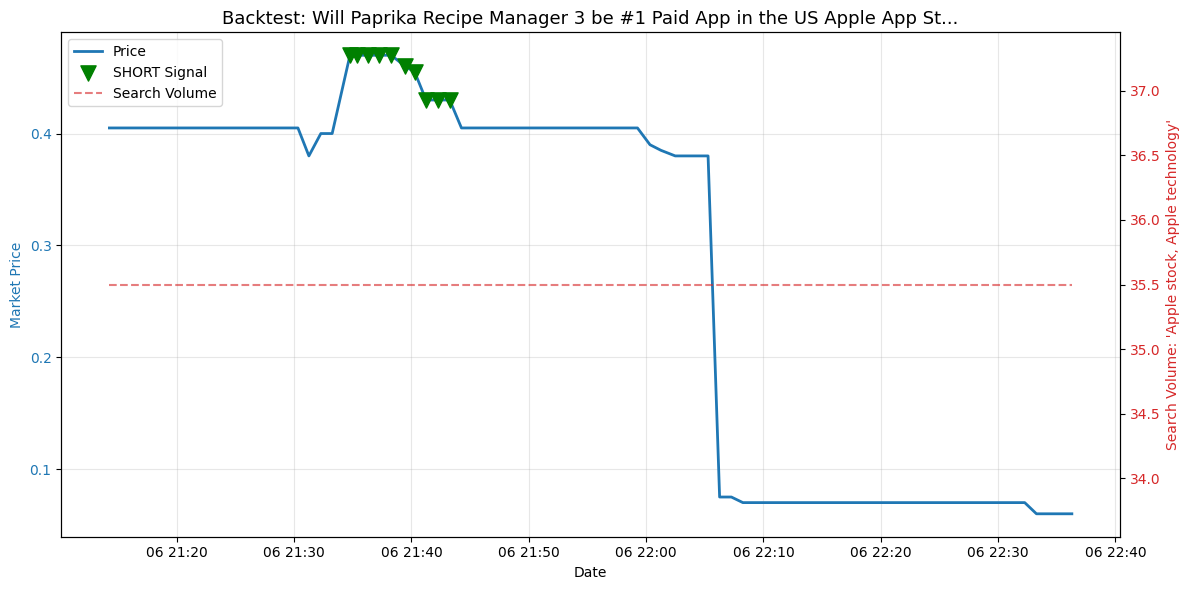

  Trades: 10  |  Win Rate: 100.0%  |  Avg P&L: $+116.9736  |  Total P&L: $+1169.7360
------------------------------------------------------------
Market: Will Bitcoin dip to $55,000 by December 31, 2026?
Keywords: ['Bitcoin price', 'Bitcoin cryptocurrency']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ['Bitcoin price', 'Bitcoin cryptocurrency']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


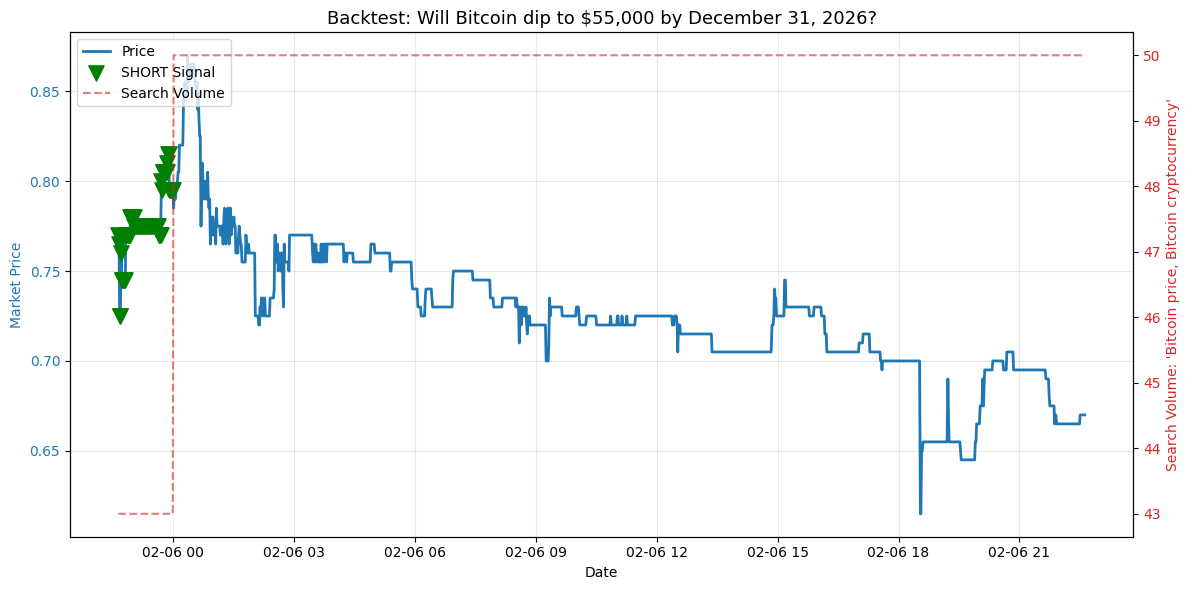

  Trades: 82  |  Win Rate: 26.8%  |  Avg P&L: $-6.3651  |  Total P&L: $-521.9369
------------------------------------------------------------
Market: Will Alien10 be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 85 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 87 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


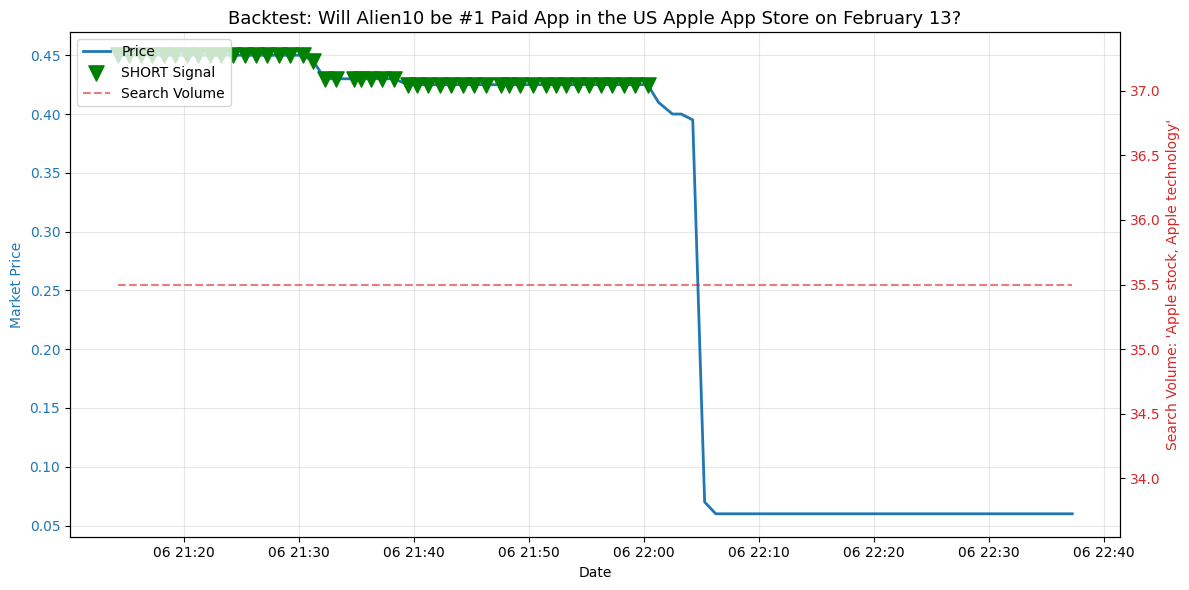

  Trades: 47  |  Win Rate: 46.8%  |  Avg P&L: $+84.2913  |  Total P&L: $+3961.6895
------------------------------------------------------------
Market: Will TonalEnergy Tuner & Metronome be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 85 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 87 days


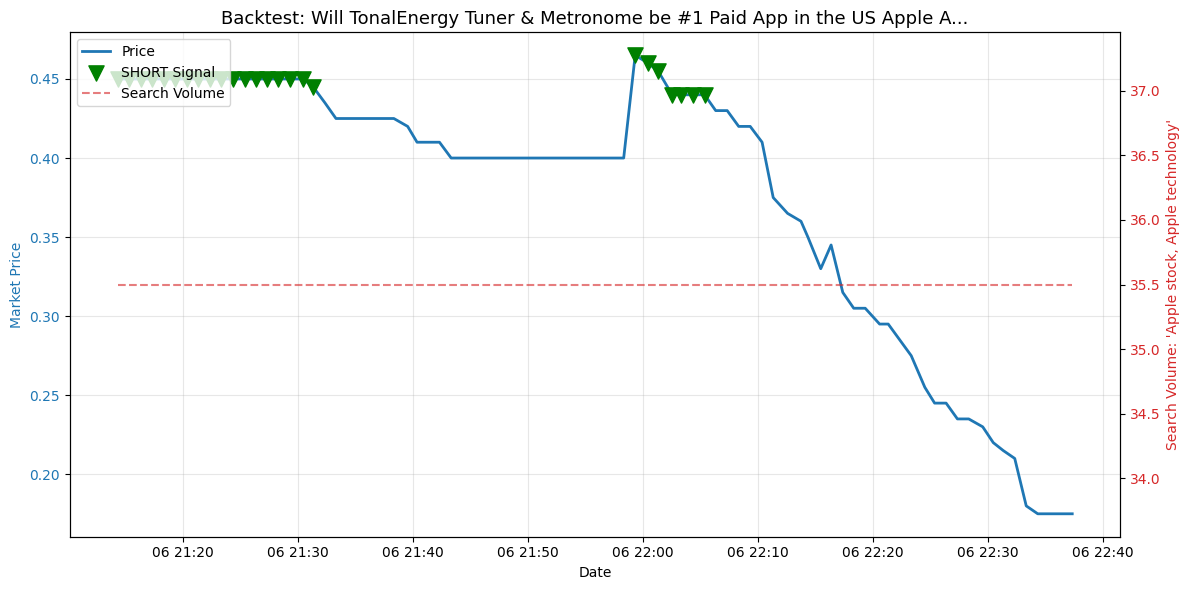

  Trades: 25  |  Win Rate: 60.0%  |  Avg P&L: $+50.8197  |  Total P&L: $+1270.4919
------------------------------------------------------------
Market: Will Countdown App be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 85 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 87 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


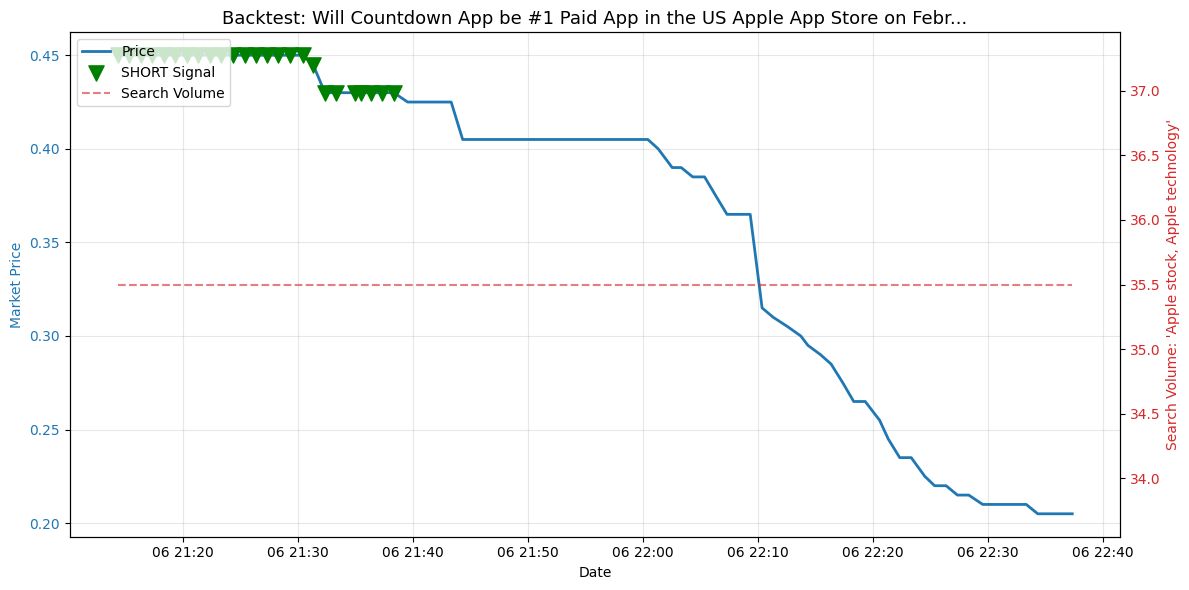

  Trades: 25  |  Win Rate: 60.0%  |  Avg P&L: $+24.2952  |  Total P&L: $+607.3803
------------------------------------------------------------
Market: Will Procreate Pocket be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 85 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 87 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


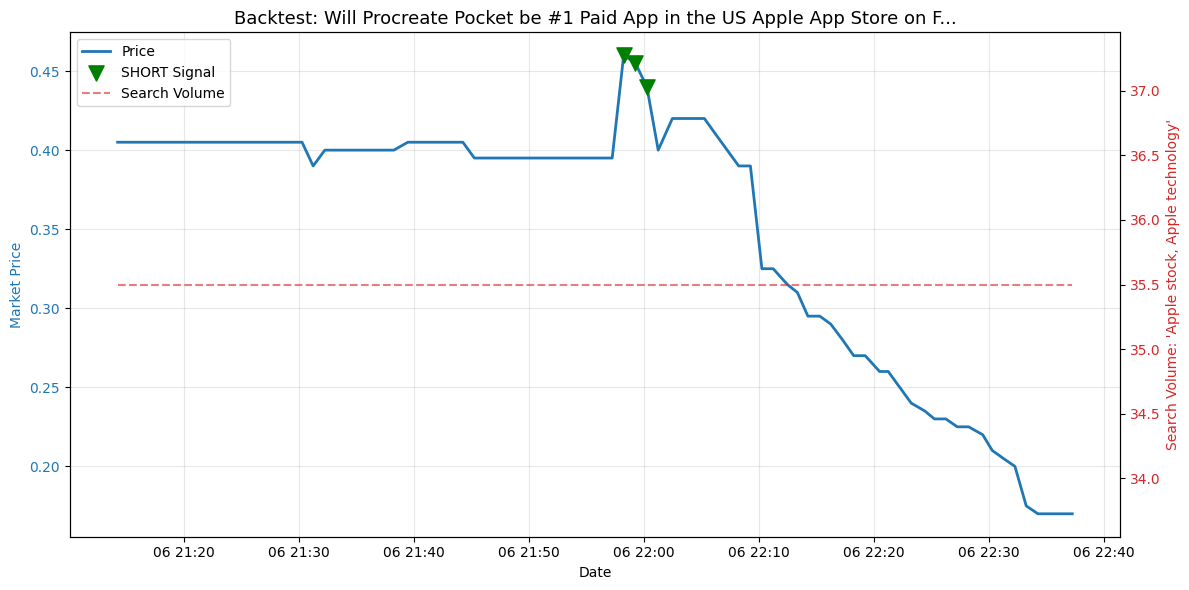

  Trades: 3  |  Win Rate: 100.0%  |  Avg P&L: $+115.3195  |  Total P&L: $+345.9584
------------------------------------------------------------
Market: Will HotSchedules be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 85 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 87 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


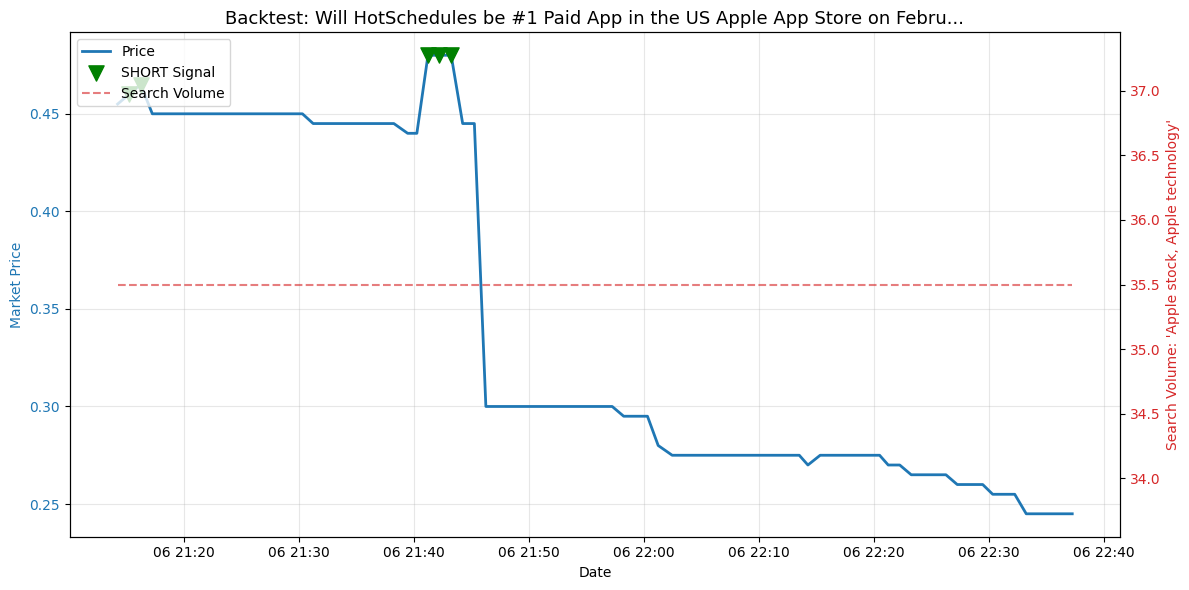

  Trades: 5  |  Win Rate: 100.0%  |  Avg P&L: $+294.7493  |  Total P&L: $+1473.7465
------------------------------------------------------------
Market: Will Shadowrocket be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 86 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 88 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


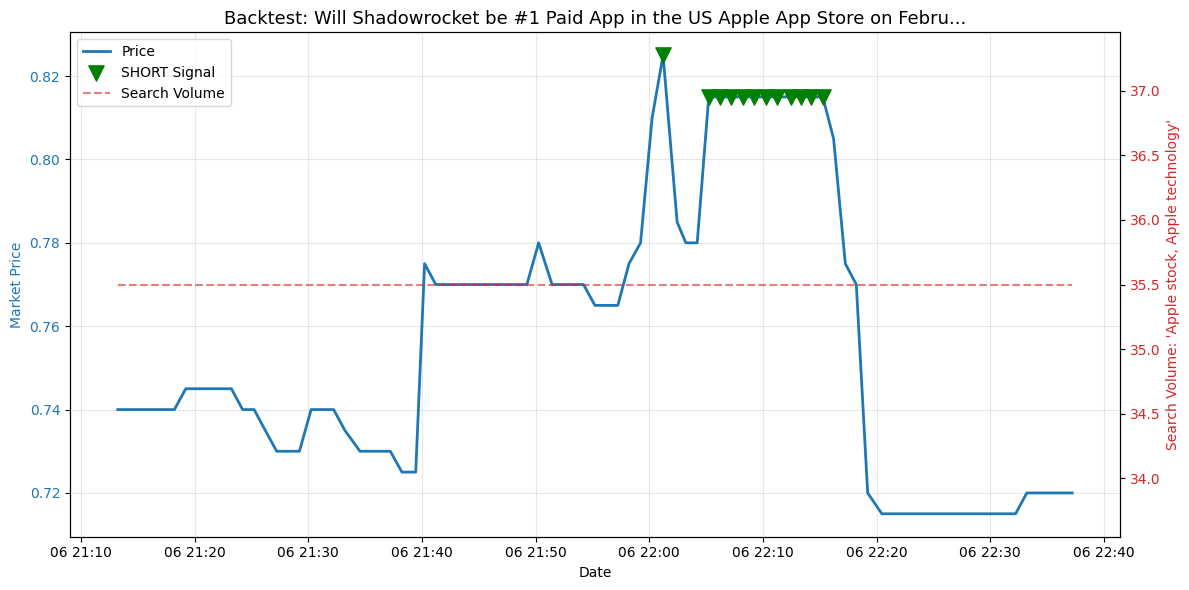

  Trades: 12  |  Win Rate: 66.7%  |  Avg P&L: $+63.8904  |  Total P&L: $+766.6853
------------------------------------------------------------
Market: Will AnkiMobile Flashcards be #1 Paid App in the US Apple App Store on February 13?
Keywords: ['Apple stock', 'Apple technology']
  Price data: 86 points over 0 days (2026-02-06 to 2026-02-06)
  Google Trends query: ['Apple stock', 'Apple technology']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 88 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


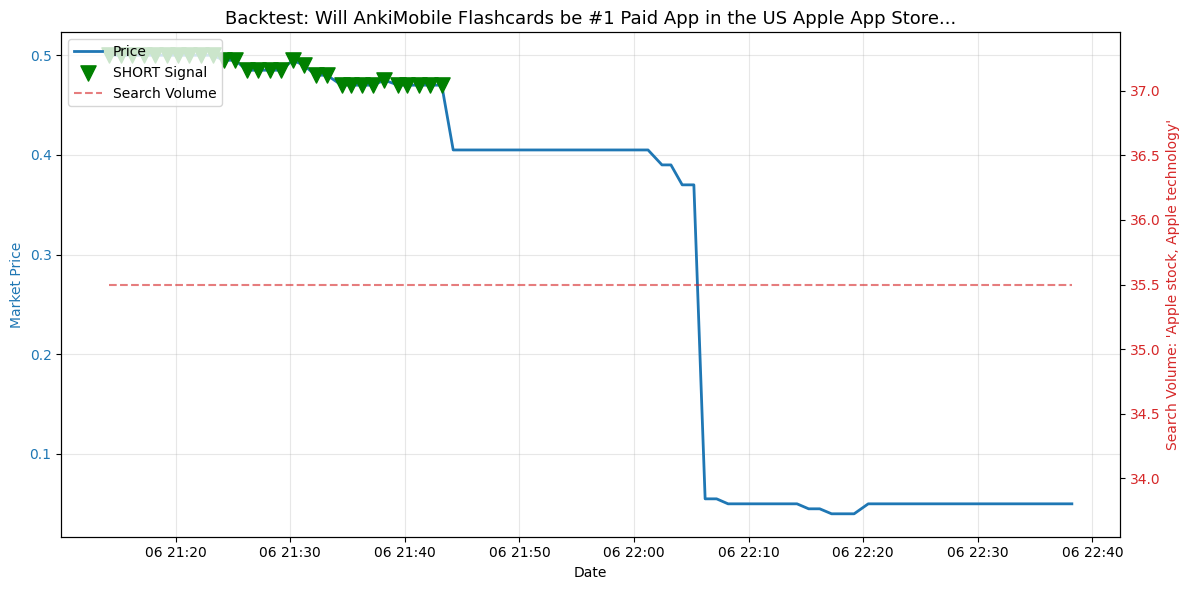

  Trades: 30  |  Win Rate: 80.0%  |  Avg P&L: $+58.0599  |  Total P&L: $+1741.7956
------------------------------------------------------------
Market: Will Coinbase say "Staking" or "Stake" during earnings call?
Keywords: ['Coinbase stock', 'Coinbase exchange']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ['Coinbase stock', 'Coinbase exchange']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


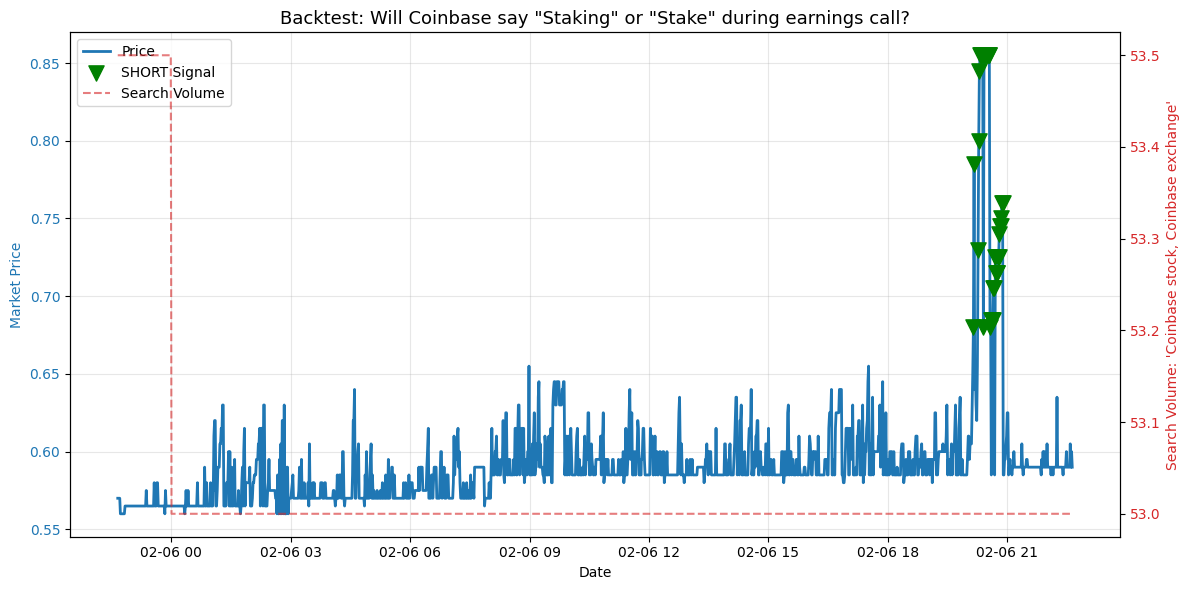

  Trades: 38  |  Win Rate: 42.1%  |  Avg P&L: $+71.2380  |  Total P&L: $+2707.0424
------------------------------------------------------------
Market: Coinbase (COIN) Up or Down on February 6?
Keywords: ['Coinbase stock', 'Coinbase exchange']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ['Coinbase stock', 'Coinbase exchange']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


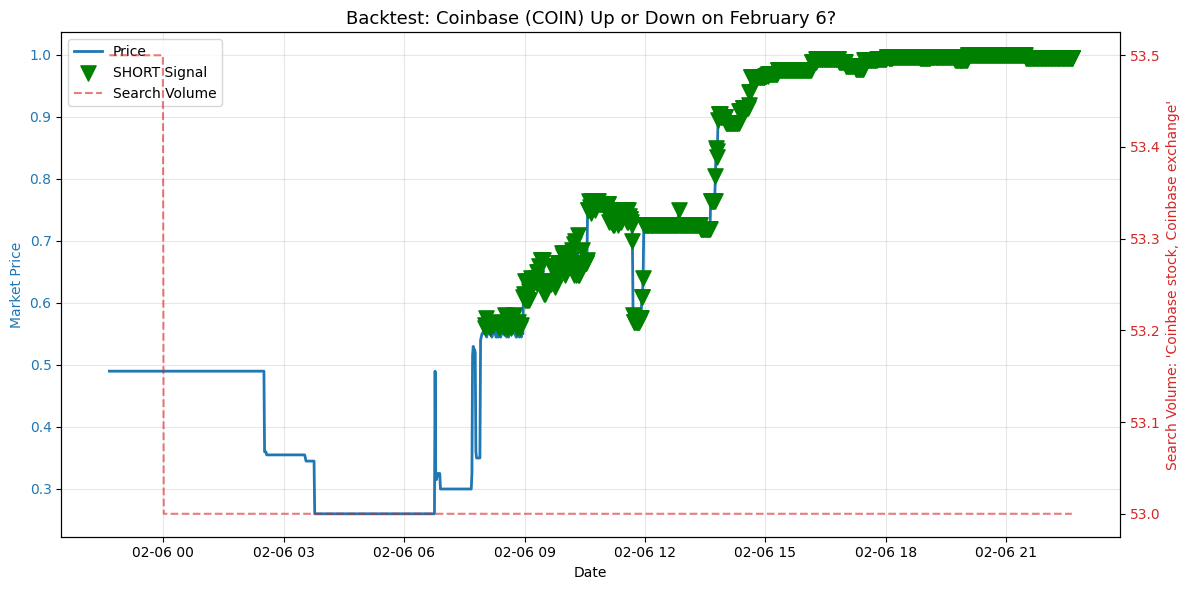

  Trades: 843  |  Win Rate: 19.3%  |  Avg P&L: $-5.5380  |  Total P&L: $-4668.5298
------------------------------------------------------------
Market: Will Amazon dip to $156 in February?
Keywords: ['Amazon stock', 'Amazon ecommerce']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ['Amazon stock', 'Amazon ecommerce']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


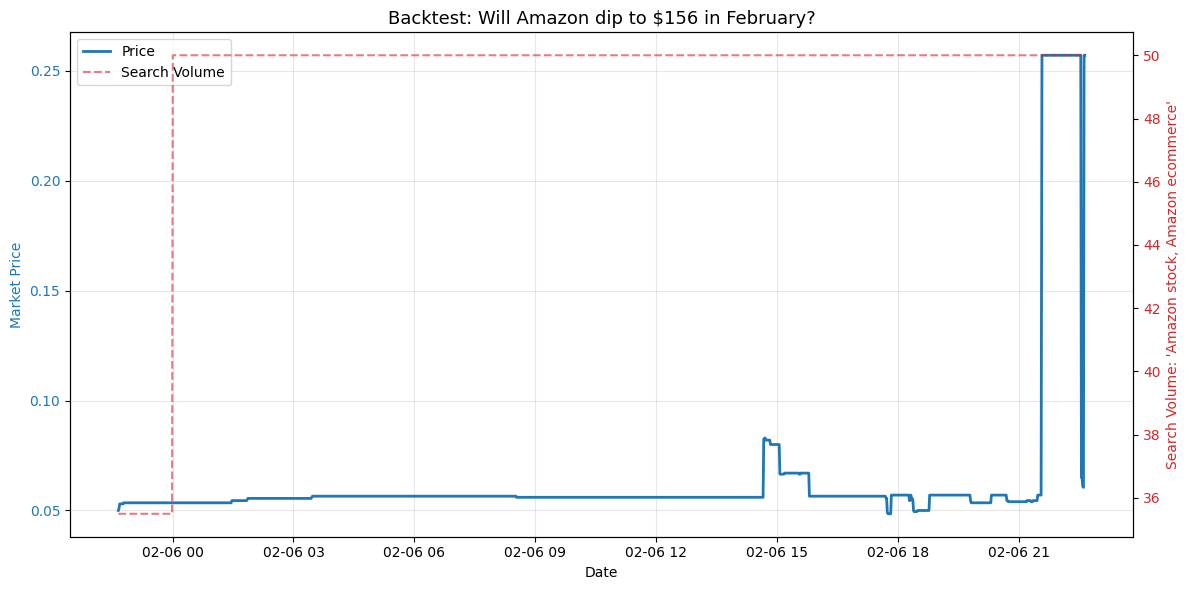

  Signals: 0 (no completed trades)
------------------------------------------------------------
Market: Will Amazon (AMZN) finish week of February 2 above $230?
Keywords: ['Amazon stock', 'Amazon ecommerce']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ['Amazon stock', 'Amazon ecommerce']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


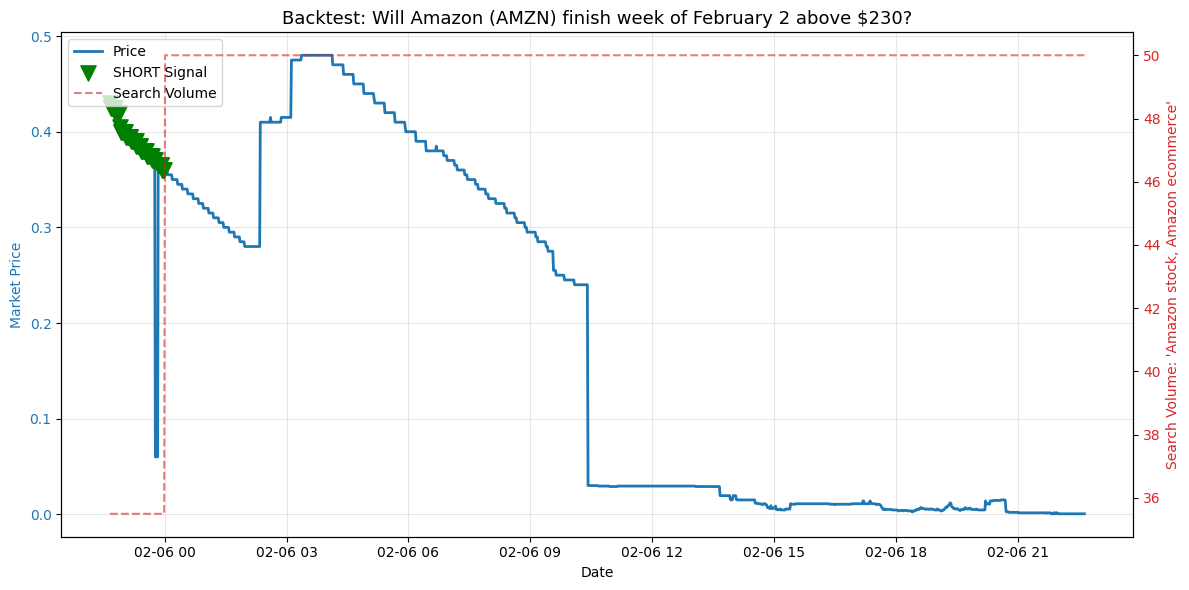

  Trades: 77  |  Win Rate: 93.5%  |  Avg P&L: $+72.4572  |  Total P&L: $+5579.2025
------------------------------------------------------------
Market: Will the price of Solana be greater than $150 on February 7?
Keywords: ['Solana price', 'Solana crypto']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ['Solana price', 'Solana crypto']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


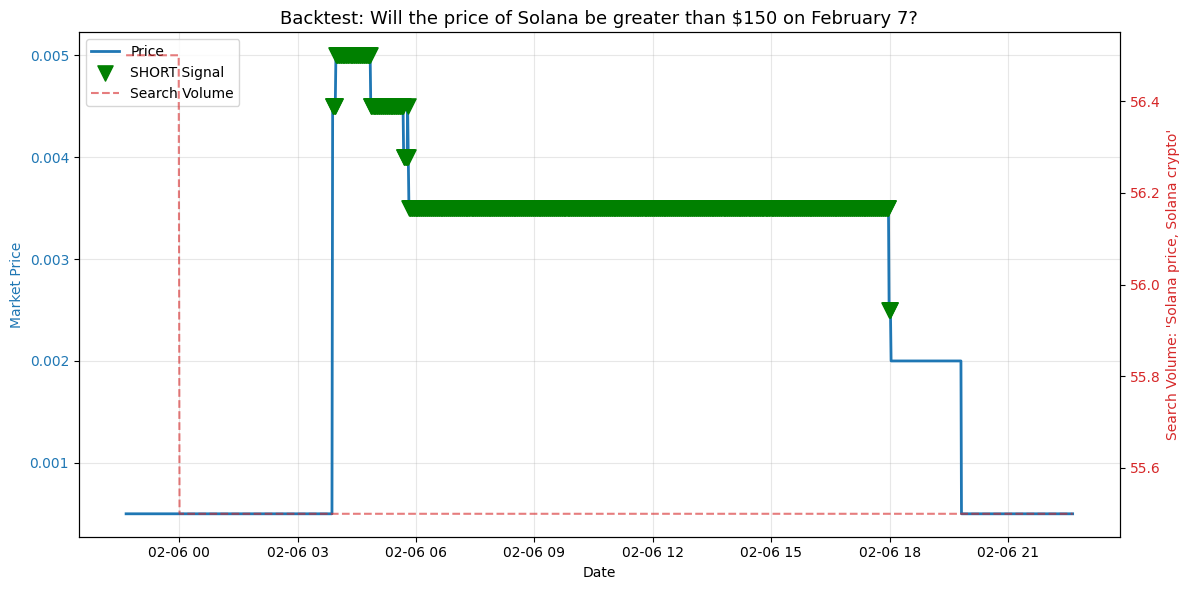

  Trades: 849  |  Win Rate: 3.5%  |  Avg P&L: $+7.2950  |  Total P&L: $+6193.4524
------------------------------------------------------------
Market: Will SpaceX's market cap be between $1.0T and $1.2T at market close on IPO day?
Keywords: ["SpaceX's price", 'IPO price']
  Price data: 1441 points over 0 days (2026-02-05 to 2026-02-06)
  Google Trends query: ["SpaceX's price", 'IPO price']
  Timeframe: 2025-11-08 2026-02-06 (90 days ending on market end date)
  Retrieved trends: 91 data points for 2/2 keywords
  Aligned data: 1443 days


/home/rayh/miniconda3/envs/quant_trading/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


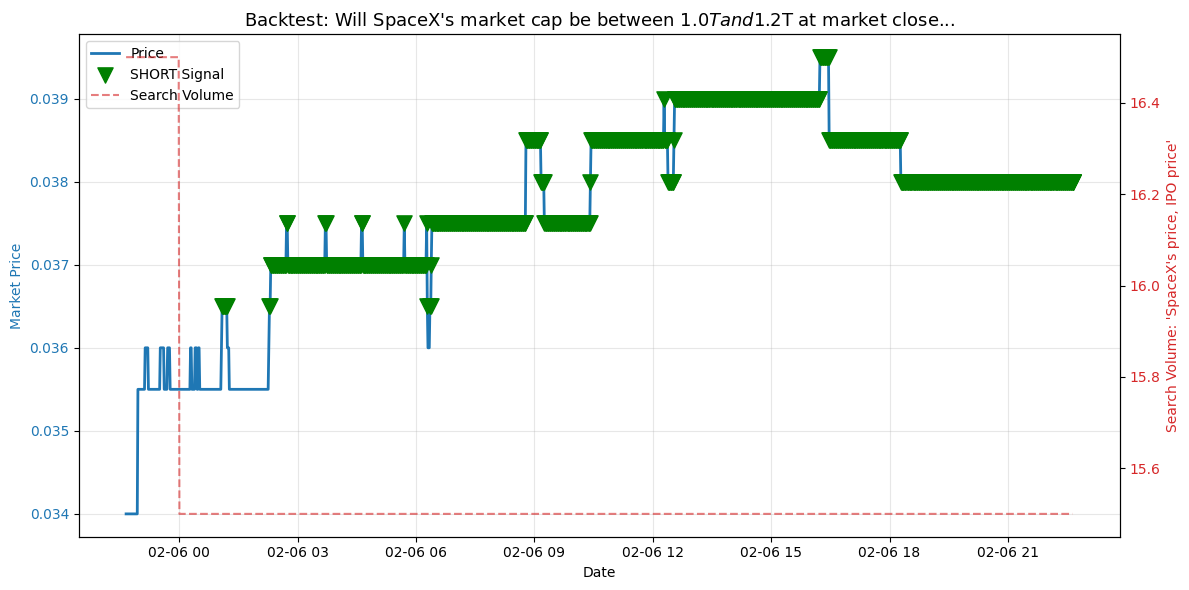

  Trades: 1230  |  Win Rate: 4.4%  |  Avg P&L: $+0.0429  |  Total P&L: $+52.7430

Processed 15 markets.

Generating portfolio performance report...



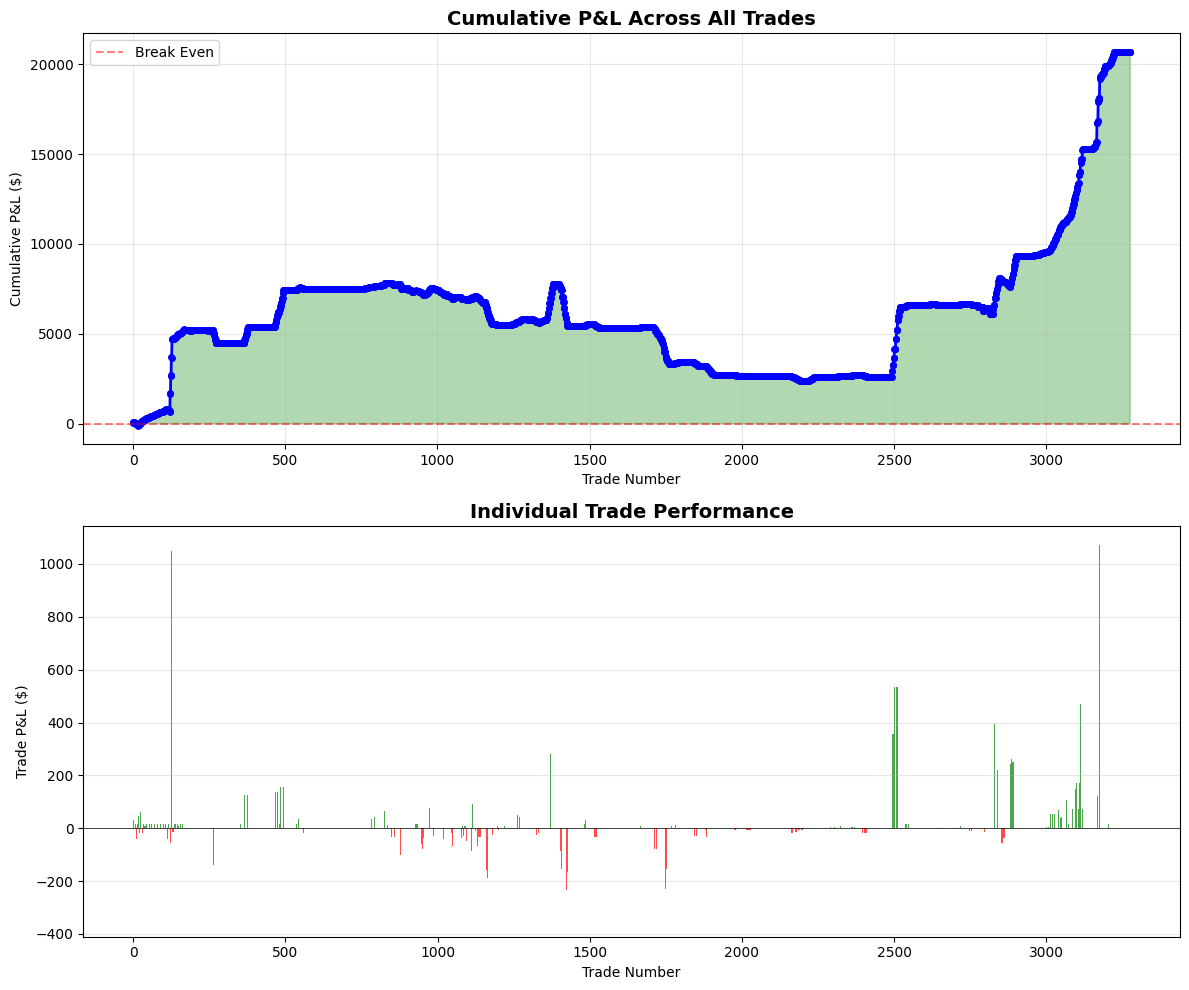


PORTFOLIO PERFORMANCE SUMMARY
Total Trades:          3276
Win Rate:              14.0%  (459W / 2817L)
Average P&L per Trade: $+6.3124
Total P&L:             $+20679.4570
Best Trade:            $+1073.5294
Worst Trade:           $-339.9123
Average Return:        +0.50%


In [ ]:
provider = DataProvider()

print('=' * 60)
print('CONTRARIAN SENTIMENT STRATEGY — BUSINESS & CRYPTO MARKETS')
print('=' * 60)
print('Fetching active markets from Polymarket...\n')

top_markets = provider.fetch_top_markets(limit=50)

if not top_markets:
    print('No qualifying business/crypto markets found.')
else:
    print(f'\nReady to process up to 15 of {len(top_markets)} markets.\n')

processed = 0
all_trades = []

for market in top_markets:
    if processed >= 15:
        break

    print('-' * 60)
    print(f"Market: {market['question']}")
    print(f"Keywords: {market['keywords']}")

    price_df = provider.fetch_market_history(market['token_id'])
    if price_df is None or price_df.empty:
        print('  No price data, skipping.')
        continue

    price_start, price_end = price_df.index[0], price_df.index[-1]
    days_span = (price_end - price_start).days
    print(f"  Price data: {len(price_df)} points over {days_span} days "
          f"({price_start.strftime('%Y-%m-%d')} to {price_end.strftime('%Y-%m-%d')})")

    trends_df = provider.fetch_search_volume(market['keywords'], price_end)
    if trends_df is None or trends_df.empty:
        print('  No trends data, skipping.')
        continue

    trends_aligned = trends_df.reindex(price_df.index, method='ffill')
    full_df = price_df.join(trends_aligned).dropna()

    if full_df.empty or len(full_df) < 7:
        print(f'  Insufficient aligned data ({len(full_df)} days), skipping.')
        continue

    print(f"  Aligned data: {len(full_df)} days")

    results = run_strategy(full_df, divergence_threshold=0.4)
    visualize_strategy(results, market['question'], market['keywords'])

    perf = calculate_performance(results, holding_days=7)
    if perf:
        print(f"  Trades: {perf['num_trades']}  |  Win Rate: {perf['win_rate']:.1f}%  |  "
              f"Avg P&L: ${perf['avg_pnl']:+.4f}  |  Total P&L: ${perf['total_pnl']:+.4f}")
        all_trades.append(perf['trades'])
    else:
        print(f"  Signals: {results['signal'].sum()} (no completed trades)")

    processed += 1

print('\n' + '=' * 60)
print(f'Processed {processed} markets.')
print('=' * 60)

if all_trades:
    print('\nGenerating portfolio performance report...\n')
    visualize_cumulative_pnl(all_trades)
else:
    print('\nNo trades were executed across any market.')